---

#**Introduction**
**Wind Speed Monitoring & Alert System**

This project aims to simulate and analyze a microcontroller-based wind speed monitoring system that provides auditory alerts and records wind speed data for further analysis. The original system was developed using the Wokwi Arduino Simulator, where a potentiometer was used to emulate varying wind speeds, an LCD for real-time display, and a buzzer that triggers when wind speed exceeds 70 km/h.

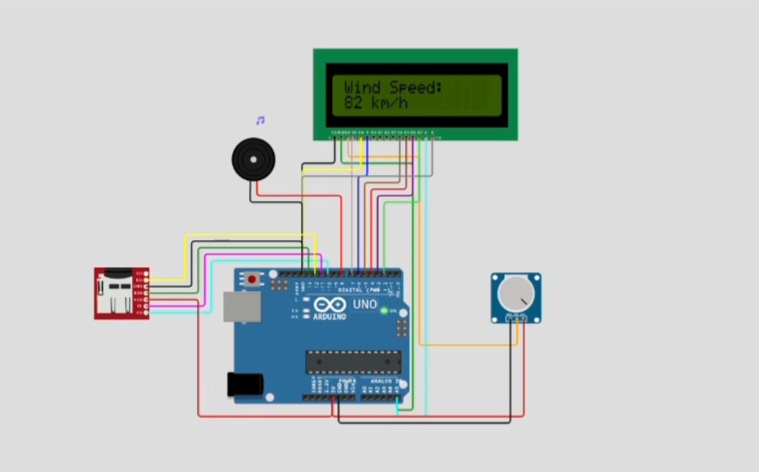



To enhance the project's impact and integrate Data Science and Machine Learning, the collected data was saved to a simulated .csv format, enabling in-depth analysis and predictive modeling.


**Tools & Technologies Used:**

- Wokwi.com: For simulating the hardware setup (Arduino Uno + LCD + Potentiometer + Buzzer + SD Card).

- Arduino C: For writing embedded control logic and collecting data.

- Python (Google Colab): For data preprocessing, visualization, and classification using pandas, matplotlib, seaborn, and sklearn.

**Dataset Collection & Import:**

After running the simulation on Wokwi for 30 minutes, the wind speed and buzzer trigger data were collected as time-series data. The exported .csv file contains three main columns:

- Time (ms): Timestamp from simulation

- WindSpeed (km/h): The calculated wind speed

- Buzzer: Whether the buzzer was triggered (True / False)


---


In [45]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

Saving wind_dataset_30min.csv to wind_dataset_30min (3).csv


In [46]:
# Import the essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [47]:
# Set visual style
sns.set(style="whitegrid")

In [48]:
# Load the Dataset
df = pd.read_csv("wind_dataset_30min.csv", sep=",")

In [49]:
# View the first few rows
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,Time(ms),WindSpeed(km/h),Buzzer
0,1033,83,1
1,2061,80,1
2,3090,74,1
3,4118,68,0
4,5146,61,0


In [50]:
# Check data info and summary
print("Data Types and Missing Values:")
print(df.info())

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Time(ms)         1804 non-null   int64
 1   WindSpeed(km/h)  1804 non-null   int64
 2   Buzzer           1804 non-null   int64
dtypes: int64(3)
memory usage: 42.4 KB
None


In [51]:
# Display a statistical summary of the dataset
print("\nStatistical Summary:")
display(df.describe())


Statistical Summary:


,Time(ms),WindSpeed(km/h),Buzzer
count,1.804000e+03,1804.000000,1804.000000
mean,9.300860e+05,50.402993,0.009978
std,5.370236e+05,7.446464,0.099417
min,1.033000e+03,29.000000,0.000000
25%,4.653972e+05,45.000000,0.000000
50%,9.298745e+05,50.000000,0.000000
75%,1.394766e+06,55.000000,0.000000
max,1.859731e+06,83.000000,1.000000


In [52]:
# Show raw column names
print("Raw column names:", df.columns.tolist())

# Clean column names
df.columns = df.columns.str.strip().str.replace('\u200b', '')  # Remove hidden unicode
df.columns = df.columns.str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

# Print cleaned column names
print("Cleaned column names:", df.columns.tolist())
print(df.dtypes)

Raw column names: ['Time(ms)', 'WindSpeed(km/h)', 'Buzzer']
Cleaned column names: ['Timems', 'WindSpeedkm/h', 'Buzzer']
Timems           int64
WindSpeedkm/h    int64
Buzzer           int64
dtype: object


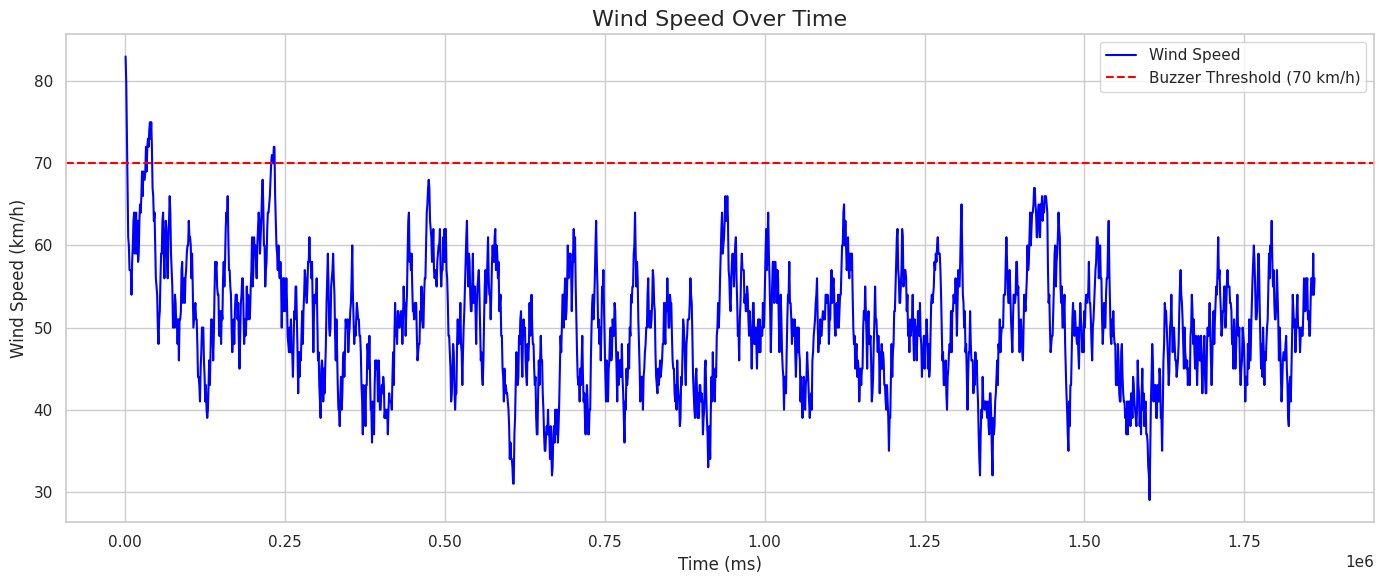

In [53]:
# Create a new figure with a defined size for better visibility
plt.figure(figsize=(14, 6))

# Plot wind speed data over time
plt.plot(df["Timems"], df["WindSpeedkm/h"], label="Wind Speed", color="blue")

# Add a horizontal line at 70 km/h to indicate the buzzer activation threshold
plt.axhline(y=70, color="red", linestyle="--", label="Buzzer Threshold (70 km/h)")

# Add title and axis labels for context
plt.title("Wind Speed Over Time", fontsize=16)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Wind Speed (km/h)", fontsize=12)

plt.legend() # Add a legend to distinguish the lines
plt.grid(True) # Add grid lines to the plot for better readability
plt.tight_layout() # Adjust layout to prevent clipping of elements
plt.show() # Display the plot



---


##**Wind Speed Visualization**

The line graph above illustrates the variation in wind speed over the full data collection period. Each point on the blue line represents a real-time wind speed reading captured during the simulation. The red dashed line at 70 km/h indicates the buzzer activation threshold defined in the embedded system logic. Whenever the wind speed exceeds this threshold, the buzzer would be triggered in the physical setup.

This visualization effectively reveals fluctuations in wind intensity, periods of relative calm, and high-speed spikes. Such patterns are crucial for analyzing environmental dynamics and understanding when alerts were or should have been activated.


---



In [55]:
# Rename all three columns
df.columns = ["Time", "WindSpeed", "Buzzer"]

# Recalculate buzzer status
df["Buzzer"] = df["WindSpeed"] >= 70

print(df.columns.tolist())

# Define buzzer threshold
threshold = 70

# Count how many times it was triggered
buzzer_count = df["Buzzer"].sum()
print(f"🔔 The buzzer would have been triggered {buzzer_count} times.")

# Calculate total buzzer-on duration in seconds (1 reading ≈ 1 sec)
duration_sec = buzzer_count
duration_min = duration_sec / 60
print(f"⏱️ Total buzzer-on time: {duration_sec} seconds ({duration_min:.2f} minutes)")

# Show first few buzzer moments
df[df["Buzzer"]].head()

['Time', 'WindSpeed', 'Buzzer']
🔔 The buzzer would have been triggered 18 times.
⏱️ Total buzzer-on time: 18 seconds (0.30 minutes)


,Time,WindSpeed,Buzzer
0,1033,83,True
1,2061,80,True
2,3090,74,True
31,32934,72,True
33,34993,72,True


In [56]:
# Define feature(s): using Wind Speed as the input for prediction
X = df[["WindSpeed"]]
y = df["Buzzer"] #whether the buzzer is active (True/False)

In [57]:
"""
Split the dataset into training and testing sets.

- 75% of the dataset will be used for training the model.
- 25% will be reserved for testing to evaluate model performance.
- The 'random_state' parameter is set to 42 to ensure that the data split is reproducible
  every time the code is run, which is important for consistency in experiments.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
"""
Initialize and train the Random Forest Classifier.

- 'n_estimators=100' means the model will use 100 decision trees in the forest.
- 'random_state=42' ensures reproducibility of the model’s behavior.
- The model is then trained (fit) using the training data (X_train, y_train),
  learning to classify whether the buzzer should activate based on wind speed.
"""
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
y_pred = model.predict(X_test)

# Results
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📈 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy: 1.0

📈 Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       451

    accuracy                           1.00       451
   macro avg       1.00      1.00      1.00       451
weighted avg       1.00      1.00      1.00       451


📉 Confusion Matrix:
 [[451]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [59]:
# Create a copy of the test feature set and add actual and predicted labels.
X_test_copy = X_test.copy()
X_test_copy["Actual_Buzzer"] = y_test.values
X_test_copy["Predicted_Buzzer"] = y_pred

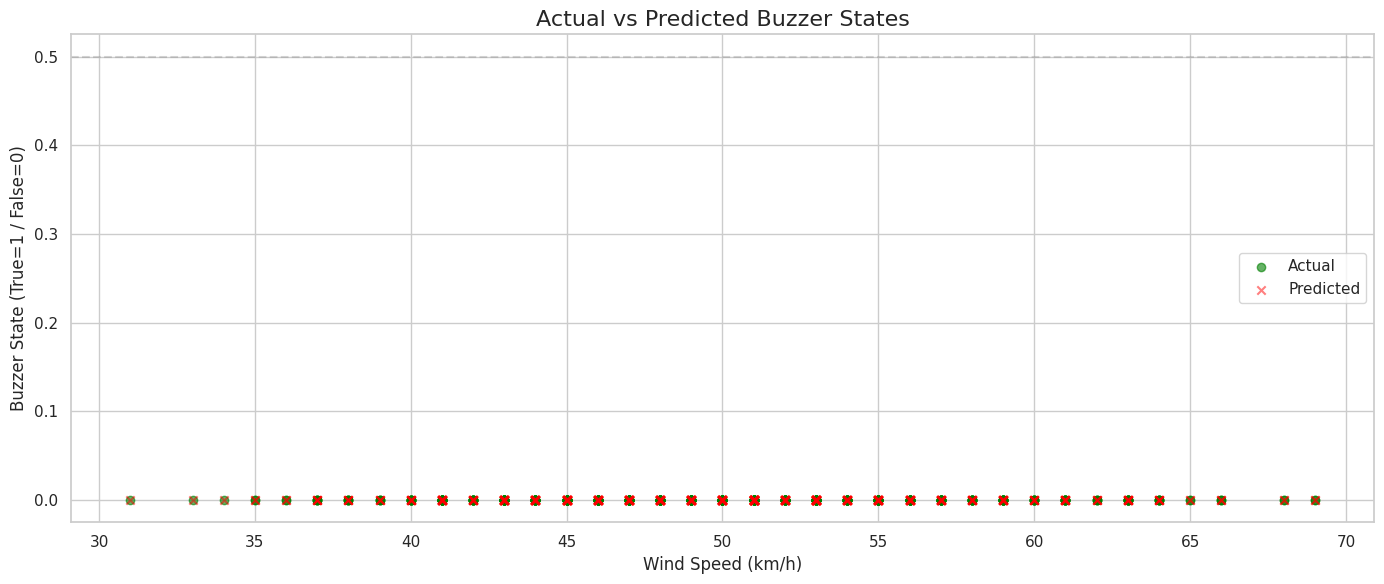

In [60]:
plt.figure(figsize=(14,6))

# Actual labels
plt.scatter(X_test_copy["WindSpeed"], X_test_copy["Actual_Buzzer"],
            color='green', label='Actual', alpha=0.6, marker='o')

# Model predictions
plt.scatter(X_test_copy["WindSpeed"], X_test_copy["Predicted_Buzzer"],
            color='red', label='Predicted', alpha=0.5, marker='x')

# Visual separator for binary classes
plt.axhline(0.5, linestyle='--', color='gray', alpha=0.3)

# Plot labels and style
plt.title("Actual vs Predicted Buzzer States", fontsize=16)
plt.xlabel("Wind Speed (km/h)", fontsize=12)
plt.ylabel("Buzzer State (True=1 / False=0)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()